# Human Diffusion

### A Q-Learning Process About The Human Migration From Africa

We start by importing the proper modules (equivalent to libraries in R).

These are

- NumPy
- MatPlotLib
- PIL, (Pillow) an image handler
- tqdm, (pronounced ta-qa-dum) from Arabic (taqadum, تقدّم) meaning *progress*, is a simple progress bar to be able to estimate the time for each task



In [1]:
#pip install -r requirements.txt

In [2]:
from earth import Earth

## Generating the Map
We initialise the picture that we want to use, and convert it into pixel values, so we can have a pure black and white image of the earth to use.

In [3]:
stage = Earth('earth.jpg')

The following forloop checks each individual pixel and the converts it to black or white. The threshold was found through running the loop many times and picking a number that looked good enough.

In [4]:
stage.black_and_white('newPixels.csv', 'pure-bw-earth.jpg')

100%|██████████| 2407680/2407680 [00:00<00:00, 2412251.10it/s]


We then generate the new picture and save it before we convert it into an array.

In [5]:
stage.generate_image('pure-bw-earth.jpg')

100%|██████████| 1254/1254 [00:03<00:00, 330.54it/s]


We are now ready to create the map we will need.

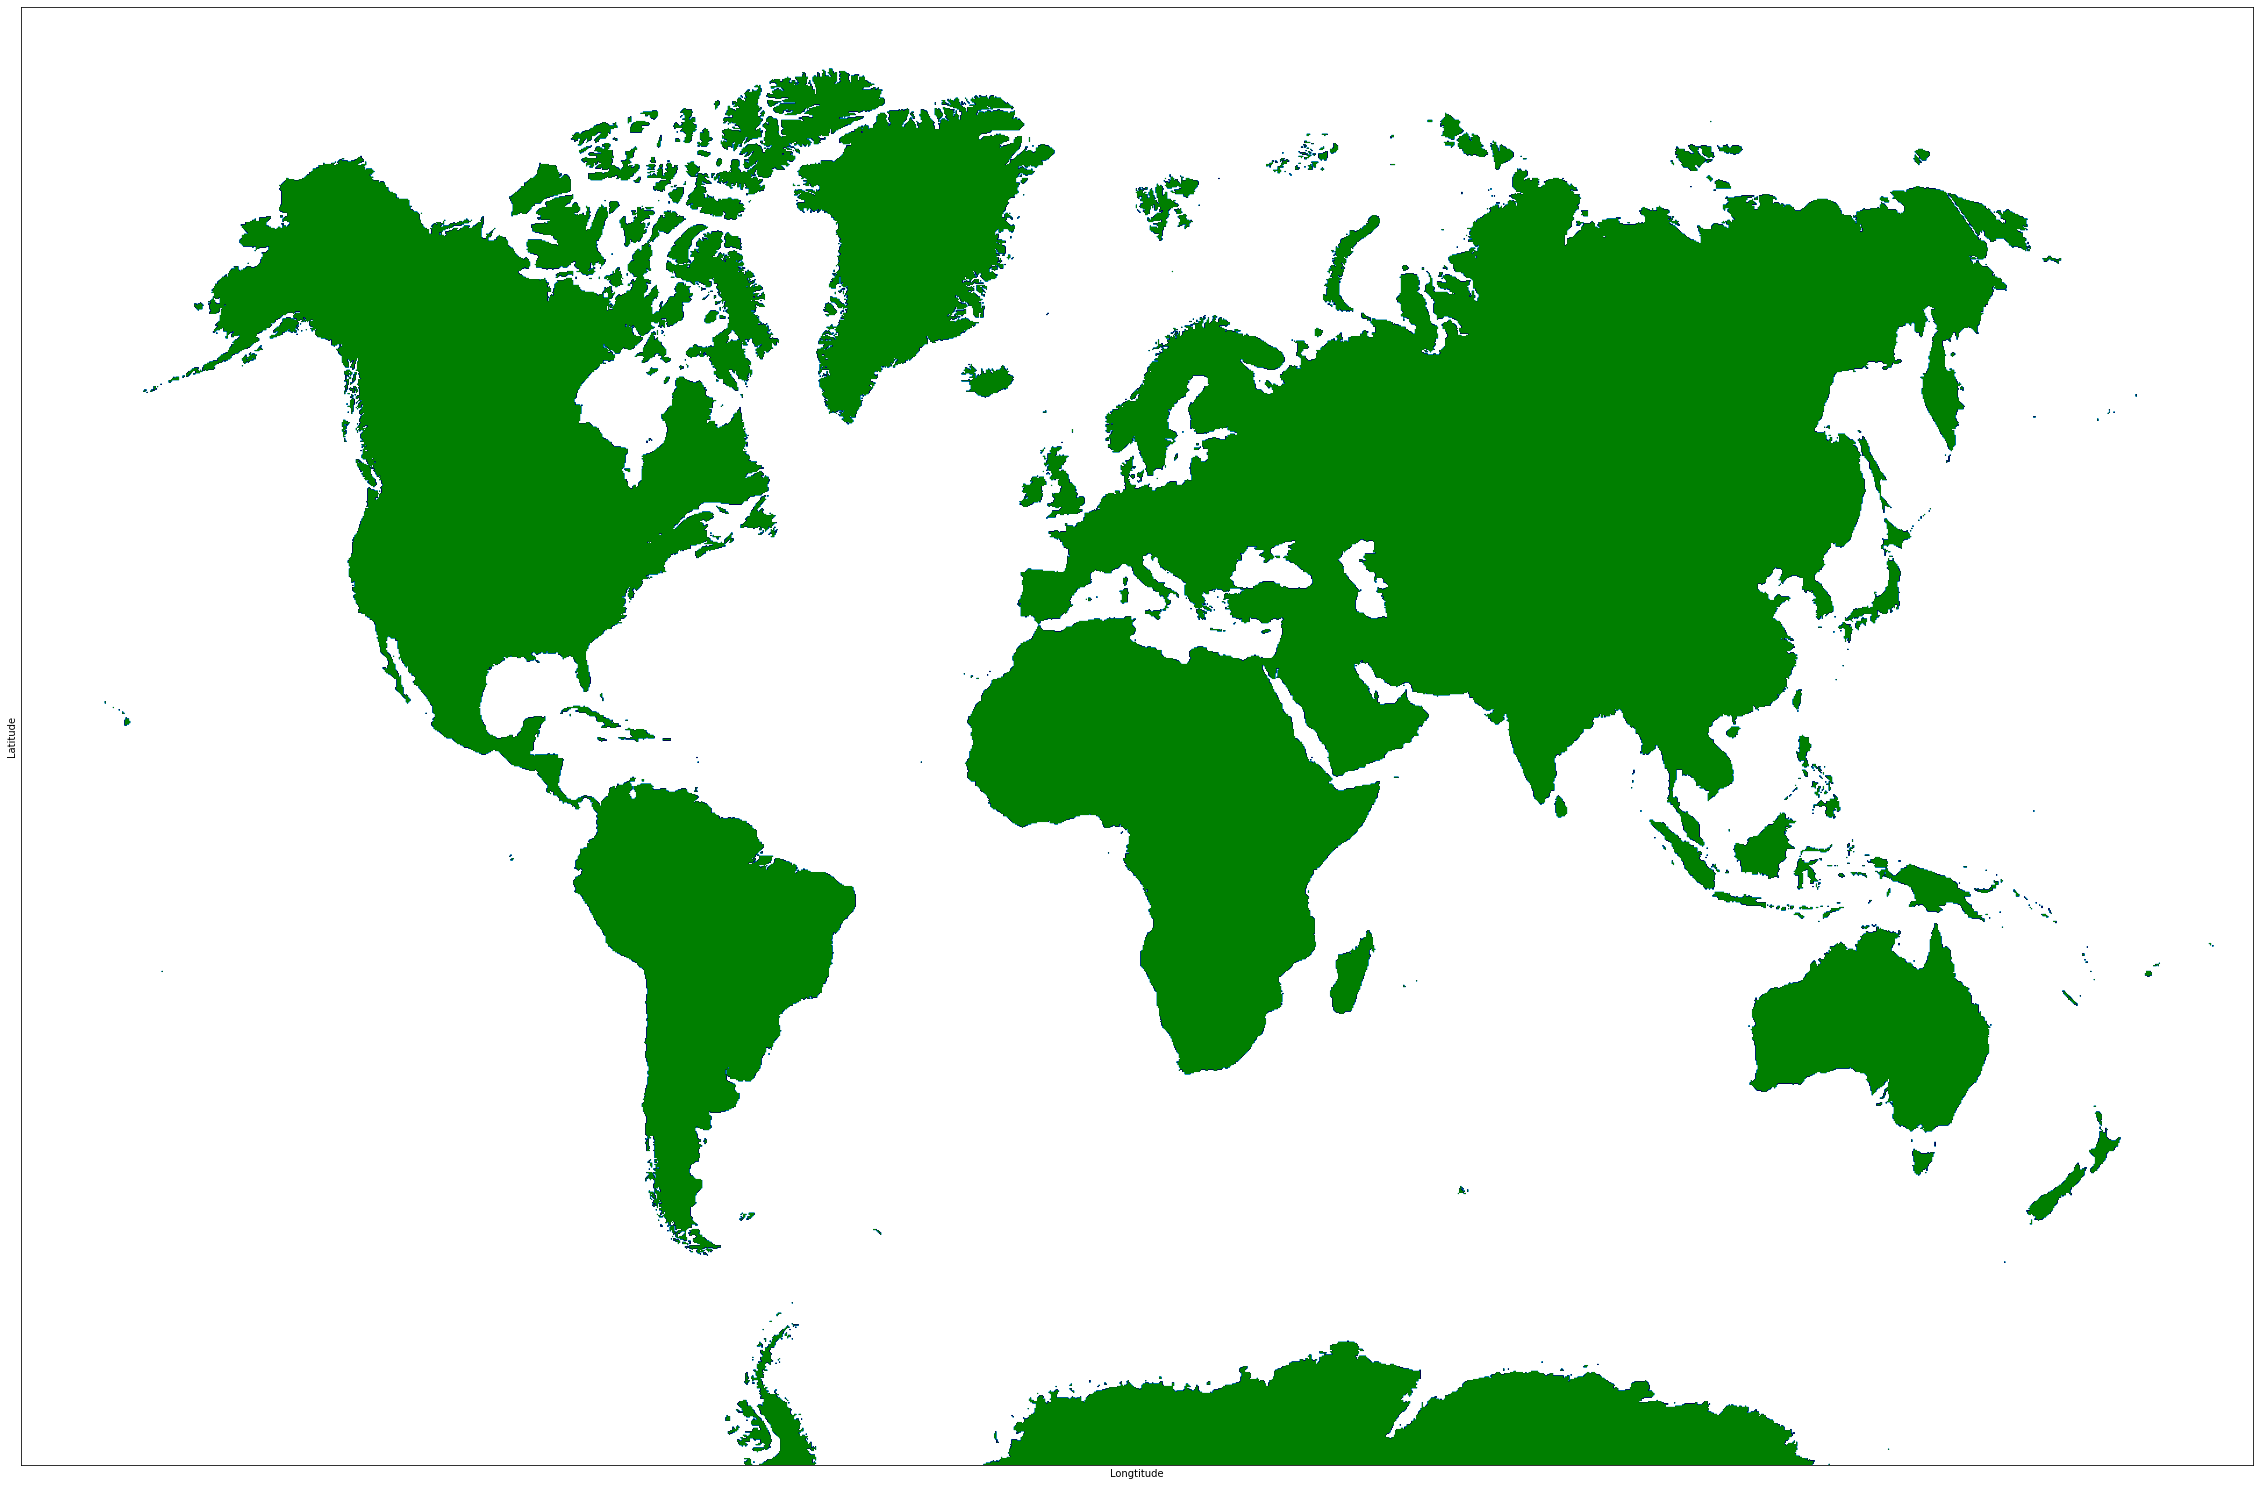

In [6]:
stage.plot('map.jpg')

Now that we have our map ready, we can move on to the implementation of the algorithm.

## The Timeline of Human Migration

The general accepted theory is that the first humans emerged in the Horn of Africa (Modern Day Ethiopia, Somalia and Eritrea), about 198 thousand years ago[1]. After 

![](migrationwaves.png)

For this project we will use the single wave dispersal model, for simplicity.

## Q-Learning

Q-Learning is a model-free reinforcment learning algorithm, meaning that it does not depend on a transition probability distribution or a reward function in order to reach the desired reult. Rather, the transition probability distribution and the reward function are collectively called the model, and the process of learning is explicitly *trial and error*. The algorithm has no prior knowledge of the data set and has to explore it, and find special areas in the data set with a high reward, with the ultimate goal of maximising it's rewards.

### The Technical Details

Q-learning is an algoritm that is able to find an optimal policy for any finite Markov decision process (FMDP) by maximizing the expected total reward over a collection of succesful steps. Given infinite time, the algorithm is able to always identify the optimal policy.

As a reinforcment learning algorithm, Q-learning requires an agent, a set of states ($S$), and a set of actions ($A$). For any action $a\in A$, the agentis able to change it's state to a new one, and the change rewards the agent with a number. Big positive numbers represent a high reward, low positive numbers a small reward, and a negative value represents a negative reward, so that the agent tries to get away from it. The overall goal of the agent is then to find a policy (path) the maximizes the total reward.

The mathematical notation for this is as follows

$$ Q:S \times R \to A $$

where $Q$ is the Q-learning algorith, $S$ is the state, $R$ is the reward, and $A$ is the action it will take.

Since the agent has no prior knowledge of the enviroment, it relies upon a set of values on which it relies upon to help it find the optimal policy, like a map. This is called a Q-table.

#### Q-Table

The Q-table is represented as a table of $N+1$ dimensions, with $N$ being the dimensions of the enviroment and the $N+1$ representing the dimesions of the enviroment plus the dimension of the actions.

A specific Q-value inside the Q-table represents the <u>*quality*</u> (hence the name Q-learning) of a specific action $a$ given a specific state $s$ and it represents the agent's estimation of the sum of future rewards. An optimal Q-table allows the agent to make the optimal actions, meaning that the Q-table represents the current policy for acting in the current enviroment.

Since on every action the state changses, we need to find a way to 
calculate the change of the Q-value for the acting taken, based on the Q-value of the resulting state, which is determined by the reward of the current state, and the expectation of future rewards.

To achieve this, we use something called Temporal Difference (TD) which is the reward received for the action taken in the previous state, plus the maximum Q-value in the current state, weighted with a discount factor, minus the Q-value of the action of the previous state

$$TD(s_{t}, a_{t}) = r_{t}+\gamma\cdot\max_{a}Q(s_{t+1},a)-Q(s_{t},a_{t}) $$

where $s_{t}$ is the previous state, $r_{t}$ is the reward in the previous state, $\gamma$ is called the *discount factor*, and $s_{t+1}$ is the current state. The discount factor $\gamma\in(0,1)$ determines the importance of future rewards, with $\gamma$ near zero meaning a greedy (trying to maximise short-term rewards) algorithm, and $\gamma$ close to 1 meaning a long-term reward goal.


#### The Bellman Equation

The Bellman equation (named after Richard Ernest Bellman(1920–1984)) is the rule used to update the value for the action taken at the previous state.

$$Q_{new}(s_{t},a_{t})=Q_{old}(s_{t},a_{t})+\alpha\cdot TD(s_{t},a_{t})$$

where $\alpha$ is the *learning rate* of the algorithm. The learning rate represents the weight Temporal Difference has on the new value, with a learning rate close to 0 implying that the algorithm is mostly exploiting prior knowledge and not exploring to a significant extent. Meanwhile, a learning rate close to 1 prioritises exploration, and for a deterministic enviroment it is the ideal value, since this creates ample chances for the agent to explore the entire space.

The entire learning process is displayed in the following diagram

<img src="q-learning.png" alt="drawing" width = "700px"/>

## Application of the Q-Learning Algorithm in the Simulation of the Single Wave Dispersal Model

In order for the algorithm to learn, we need to create an enviroment, an agent who interacts with the environment and a set of actions for the agent to be able to make.

* For the enviroment we use the map we have generated before, with special checkpoints spread around in areas of significance from the previous section. This means that we are interested for creating a model where the agent follows the following path:
    1. The agent starts in Ethiopia
    2. At some point the agent discovers Arabia and crosses the strait connecting the Red Sea with the Gulf of Aden
    3. Following the coastline, the agent reaches the Strait of Hormuz, and reaches Iran.
    4. Upon reaching North India there should be a double dispersal, one following the Himalayan mountains and then turning North, and the other through South India
    5. The North Group then turns West towards the Caspian Sea, ultimately reaching Europe, while the South Group goes through Siam and Indonesia to reach Australia.
* The actions that the agent is able to do are: **go north**, **go south**, **go east**, and **go west**.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
actions = ['west', 'east', 'north', 'south']
#coded to 0, 1, 2, 3

Then we can generate the Q-map, which gives the rewards.

In [9]:
def starting_area(column, row):
    col = np.random.randint(column[0], column[1])
    row = np.random.randint(row[0], row[1])
    return col, row
    
    
def next_action(current_height, current_width, epsilon):
    if np.random.random() < epsilon:
        move = np.argmax(q_values[current_height, current_width])
    else:
        move = np.random.randint(4)
    return move
    
    
def next_location(height, width, action):
    new_width = width
    new_height = height
    
    if actions[action] == 'west':
        if width == 0:
            new_width = stage.width -1
        else:
            new_width = width - 1
            
    if actions[action] == 'east':
        if width == stage.width - 1:
            new_width = 0
        else:
            new_width = width + 1
            
    if actions[action] == 'north' and height > 1:
        new_height = height -1
    
    if actions[action] == 'south' and height < stage.height:
        new_height = height +1
        
   
    return new_height, new_width
            

Put on some Mortal Kombat music cause it's about to get serious

In [10]:
q_values = np.random.uniform(size=(stage.height,stage.width, len(actions)))

In [19]:
reward_map = -np.ones(shape=(stage.height,stage.width))
reward_map[np.where(stage.map > 0)] = -20
reward_map[0:3, 0:3] = -50

real_map = np.zeros(shape=(stage.height,stage.width))
real_map[np.where(stage.map > 0)] = 5

avg_life = np.arange(0, 50)
timeline = np.arange(0, 4000)

for episode in tqdm(np.arange(10)): #30k
    
    #Arabian bridge
    reward_map[650:660, 1115:1125] = 1
    reward_map[650:660, 1125:1135] = 1
    reward_map[635:640, 1135:1140] = 10
    
    #Hormuz bridge
    reward_map[610:615, 1190:1195] = 10
    reward_map[570:600, 1183:1193] = 1
    reward_map[575:580, 1200:1205] = 10
    
    #India
    reward_map[575:580, 1250:1255] = 10
    reward_map[625:630, 1295:1300] = 10
    reward_map[595:600, 1380:1385] = 10
    
    #Siamese bridge
    reward_map[710:730, 1430:1440] = 1
    reward_map[705:710, 1435:1440] = 10
    
    #Indonesian bridge 1
    reward_map[745:765, 1450:1460] = 1
    reward_map[750:755, 1445:1450] = 10


    #Indonesian bridge 2
    reward_map[765:785, 1500:1580] = 1
    reward_map[765:820, 1550:1580] = 1
    reward_map[775:780, 1550:1555] = 10

    #Australia
    reward_map[860:890, 1530:1560] = 15
    
    old_height, old_width = 685, 1110
    epsilon = 0.9
    discount_factor = 0.9
    learning_rate = 1
    
    for age in timeline:
        if age >= 30:
            reward_map[650:660, 1115:1125] = -1
            reward_map[650:660, 1125:1135] = -1
            reward_map[635:640, 1135:1140] = -1
        
        if age >= 100:
            reward_map[610:615, 1190:1195] = -1
            reward_map[570:600, 1183:1193] = -1
            reward_map[575:580, 1200:1205] = -1
        
        if age >= 1500:
            reward_map[575:580, 1250:1255] = -1
            
        if age >=1700:
            reward_map[625:630, 1295:1300] = -1
        
        if age >=2000:
            reward_map[595:600, 1380:1385] = -1
            
        if age >= 3000:
            reward_map[710:730, 1430:1440] = -1
            reward_map[705:710, 1435:1440] = -1
        
        if age >= 3300:
            reward_map[745:765, 1450:1460] = -1
            reward_map[750:755, 1445:1450] = -1
            
        if age >= 3700:
            reward_map[765:785, 1500:1580] = -1
            reward_map[765:820, 1550:1580] = -1
            reward_map[775:780, 1550:1555] = -1
        
        if reward_map[old_height, old_width] == -20:
            break
        else:
            height, width = starting_area([old_height-5, old_height+5], [old_width-5, old_width+5])
            

        real_map[old_height-5:old_height+5, old_width-5:old_width+5] = 20
                
        for year in avg_life:
            try:
                action = next_action(height, width, epsilon)
                old_height, old_width = height, width
                height, width = next_location(height, width, action)

                reward = reward_map[height, width]
                old_q_value = q_values[old_height, old_width, action]
                temporal_difference = reward + (discount_factor*np.max(q_values[height, width])) - old_q_value

                new_q_value = old_q_value + (learning_rate * temporal_difference)
                q_values[old_height, old_width, action] = new_q_value
                real_map[old_height, old_width] = 20
                
            except IndexError as e:
                continue

                

100%|██████████| 10/10 [00:01<00:00,  5.00it/s]


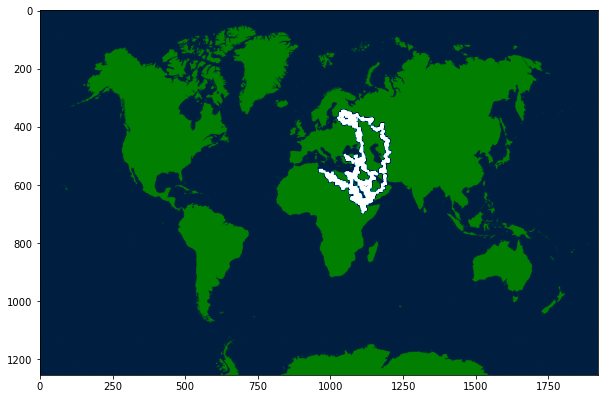

In [20]:
fig = plt.figure(figsize = (10,10))
plt.imshow(real_map, cmap = 'ocean')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


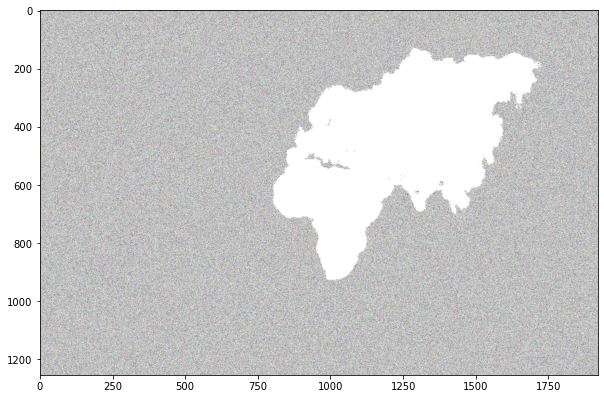

In [14]:
fig = plt.figure(figsize = (10,10))
plt.imshow(q_values, cmap = 'magma')
plt.show()

## References

[1] McDougall, I., Brown, F. & Fleagle, J. *Stratigraphic placement and age of modern humans from Kibish, Ethiopia.* **Nature** 433, 733–736 (2005). https://doi.org/10.1038/nature03258

[2] López S, van Dorp L, Hellenthal G. *Human Dispersal Out of Africa: A Lasting Debate.* **Evol Bioinform Online.** 2016 Apr 21; 11(Suppl 2):57-68. doi: https://doi.org/10.4137/EBO.S33489

[3] Yang M. *A genetic history of migration, diversification, and admixture in Asia.* **Hum Popul Genet Genom.** 2022; 2(1):0001. https://doi.org/10.47248/hpgg2202010001